In [1]:
from segmentandoDatasets import segmentando_datasets

segmentando_datasets(1000,1000,1000)


DataFrame do local PUC salvo como: Datasets_csv/df_PUC.csv
DataFrame do local PUC:
                                      caminho_imagem    classe
0  /home/lucas/Downloads/PKLot/PKLotSegmented/PUC...  Occupied
1  /home/lucas/Downloads/PKLot/PKLotSegmented/PUC...     Empty
2  /home/lucas/Downloads/PKLot/PKLotSegmented/PUC...     Empty
3  /home/lucas/Downloads/PKLot/PKLotSegmented/PUC...     Empty
4  /home/lucas/Downloads/PKLot/PKLotSegmented/PUC...     Empty


DataFrame do local UFPR04 salvo como: Datasets_csv/df_UFPR04.csv
DataFrame do local UFPR04:
                                      caminho_imagem    classe
0  /home/lucas/Downloads/PKLot/PKLotSegmented/UFP...     Empty
1  /home/lucas/Downloads/PKLot/PKLotSegmented/UFP...     Empty
2  /home/lucas/Downloads/PKLot/PKLotSegmented/UFP...  Occupied
3  /home/lucas/Downloads/PKLot/PKLotSegmented/UFP...     Empty
4  /home/lucas/Downloads/PKLot/PKLotSegmented/UFP...     Empty


DataFrame do local UFPR05 salvo como: Datasets_csv/df_UFPR05.csv


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint



2024-08-30 15:29:40.009734: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-30 15:29:40.025229: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-30 15:29:40.029687: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-30 15:29:40.041374: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-30 15:29:41.664955: W tensorflow/compiler/tf2

In [3]:
from preprocessamento import *

csv_file = 'Datasets_csv/df_PUC.csv'
train, teste, val, _, _, _ = preprocessamento(csv_file, 0.6, 0.2, 0.2, True)

Found 600 validated image filenames.
Found 200 validated image filenames.
Found 200 validated image filenames.


In [4]:
print(train.dtype)

print(train)

float32


In [5]:
"""x_train = next(train)

diff = x_train[0][0] - x_train[1][0]
print(np.sum(diff))"""

'x_train = next(train)\n\ndiff = x_train[0][0] - x_train[1][0]\nprint(np.sum(diff))'

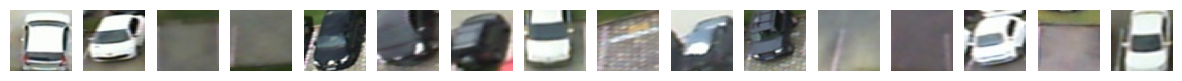

In [6]:
images, labels = next(train)

fig, axes = plt.subplots(1, 16, figsize=(15, 5))

for i in range(16):
    axes[i].imshow(np.clip(images[i], 0, 255).astype('uint8'))
    axes[i].axis('off') 

plt.show()

In [7]:
class NormalizedDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_iterator):
        self.data_iterator = data_iterator

    def __len__(self):
        return len(self.data_iterator)

    def __getitem__(self, idx):
        batch = self.data_iterator[idx]
        if isinstance(batch, tuple):
            return (batch[0] / 255.0, batch[0] / 255.0)  # Normalize input and target
        else:
            return batch / 255.0

In [8]:
class Autoencoder(Model):
    def __init__(self, input_shape=(256, 256, 3)):
        super(Autoencoder, self).__init__()
        self.input_shape = input_shape

        self.encoder = tf.keras.Sequential([
            layers.Input(shape=input_shape),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=2)
        ])

        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(128, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(3, kernel_size=3, strides=2, activation='sigmoid', padding='same')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [9]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    return lr

In [10]:
autoencoder = Autoencoder()

I0000 00:00:1725042585.699254  400781 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725042585.862417  400781 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725042585.862573  400781 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725042585.863631  400781 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [11]:
#autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                    loss='mse')

In [12]:
from tensorflow.keras import layers, Model, callbacks


#checkpoint_path = 'weights_parciais/weights-improvement-{epoch:02d}-{loss:.2f}.weights.h5'
"""cp_callback = ModelCheckpoint(filepath=checkpoint_path, 
                                  save_weights_only=True, 
                                  monitor='loss',
                                  mode='max', 
                                  save_best_only=True, 
                                  verbose=1)"""

cp_callback = callbacks.ModelCheckpoint(filepath='best_model.keras',
                                        save_best_only=True,
                                        monitor='val_loss')
early_stopping = callbacks.EarlyStopping(monitor='val_loss',
                                         patience=10,
                                         restore_best_weights=True)
lr_scheduler = callbacks.LearningRateScheduler(lr_schedule)



In [13]:
train_gen = NormalizedDataGenerator(train)
val_gen = NormalizedDataGenerator(val)

In [14]:
history = autoencoder.fit(train_gen,
                          epochs=100,
                          validation_data=val_gen,
                          callbacks=[cp_callback, early_stopping, lr_scheduler],
                          verbose=1)

Epoch 1/100


/home/lucas/PIBIC/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725042589.145808  400877 service.cc:146] XLA service 0x73b934011a70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725042589.145827  400877 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1660, Compute Capability 7.5
2024-08-30 15:29:49.207853: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-30 15:29:49.390235: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
E0000 00:00:1

 2/19 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0560

I0000 00:00:1725042594.682966  400877 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0538

E0000 00:00:1725042597.253951  400878 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1725042597.405348  400878 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Training Loss (Log Scale)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

In [ ]:
autoencoder.save('Modelos_keras/Autoencoder2.keras')
autoencoder.save_weights('weights_finais/Autoencoder2.weights.h5')

In [ ]:
autoencoder.load_weights('weights_finais/Autoencoder2.weights.h5')

In [ ]:
encoded_imgs = autoencoder.encoder(train[0])
decoded_imgs = autoencoder.decoder(encoded_imgs)

In [ ]:
print(encoded_imgs.shape)
decoded_imgs.shape

In [ ]:
#x_test = next(teste)

In [ ]:
print(np.unique(decoded_imgs[0]))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

input_imgs, _ = train[0]  # Extraia as imagens

num_imgs = min(encoded_imgs.shape[0], 5)  # Por exemplo, visualize no máximo 5 imagens
num_channels = encoded_imgs.shape[-1]  # Número de canais
num_channels_to_show = min(num_channels, 10)  # Número de canais a mostrar por imagem

fig, axes = plt.subplots(3, num_imgs, figsize=(15, 9))

for i in range(num_imgs):
    axes[0, i].imshow(np.clip(input_imgs[i], 0, 255).astype('uint8'))
    axes[0, i].axis('off')
    axes[0, i].set_title('Original')

for i in range(num_imgs):
    axes[1, i].imshow(np.clip(decoded_imgs[i], 0, 255).astype('uint8'))
    axes[1, i].axis('off')
    axes[1, i].set_title('Decodificado')

for i in range(num_imgs):
    encoded_img = encoded_imgs[i]
    for j in range(num_channels_to_show):
        axes[2, i].imshow(encoded_img[:, :, j], cmap='gray')
        axes[2, i].axis('off')
        axes[2, i].set_title(f'Codificada')

plt.tight_layout()
plt.show()


In [ ]:
#UFPR04, _ = preprocessamento_dataframe_unico("Datasets_csv/df_UFPR04.csv", True)

In [ ]:
"""x_UFPR04, _ = next(UFPR04)

x_UFPR04 = x_UFPR04.astype('float32')/255.

print(x_UFPR04.shape)"""